<a href="https://colab.research.google.com/github/nelaaulina/AI-Praktikum_G.231.20.0164/blob/main/AIPraktikum8_G_231_20_0164.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
# First, we get the data
dataset = pd.read_csv('Praktikum8RNN.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [5]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

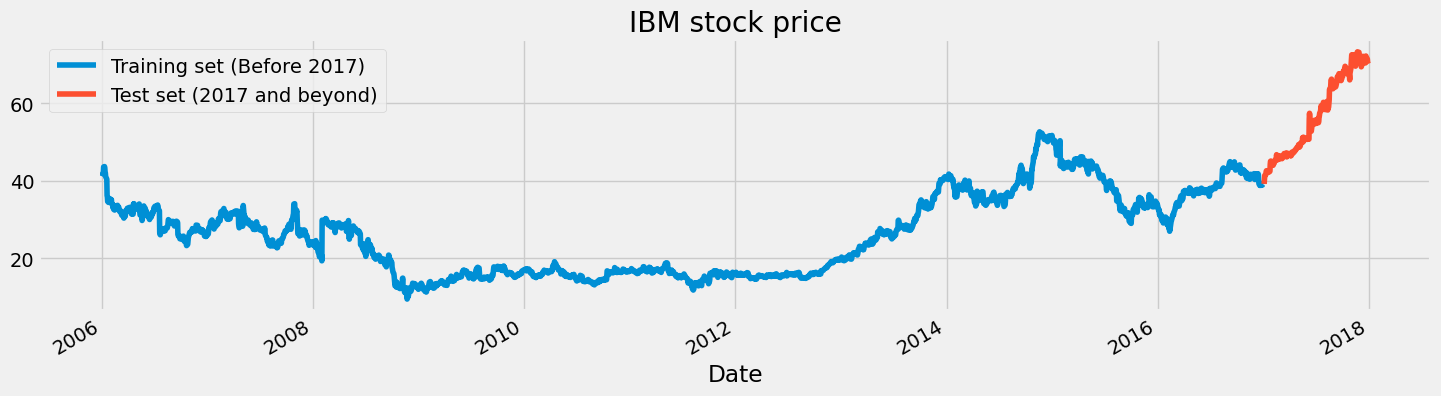

In [6]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [22]:
# Correlation matrix
dataset.corr()['Close']

<ipython-input-22-3d1a64638330>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()['Close']


Open      0.999322
High      0.999665
Low       0.999717
Close     1.000000
Volume   -0.179365
Name: Close, dtype: float64

In [23]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

count    3.019000e+03
mean     2.158391e+07
std      1.926231e+07
min      1.939061e+06
25%      1.248025e+07
50%      1.732130e+07
75%      2.512757e+07
max      4.382317e+08
Name: Volume, dtype: float64


<Axes: >

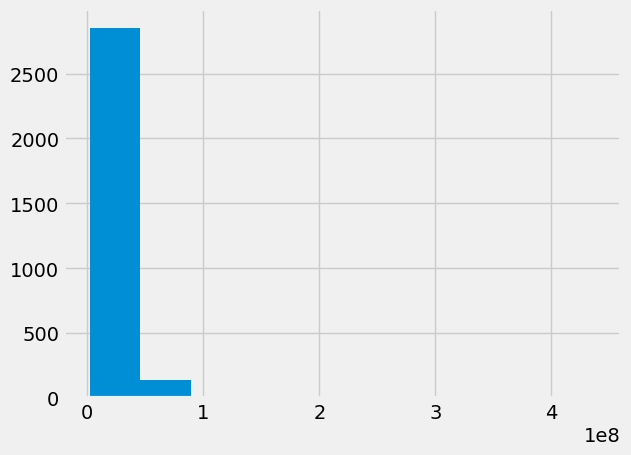

In [27]:
# Distribution of Various Features
print(dataset.describe().Volume)
dataset.drop(dataset[dataset['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
dataset['Volume'].hist(bins = 10)

In [30]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                        activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [31]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)

    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [32]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [33]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [36]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [37]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 27ms/step


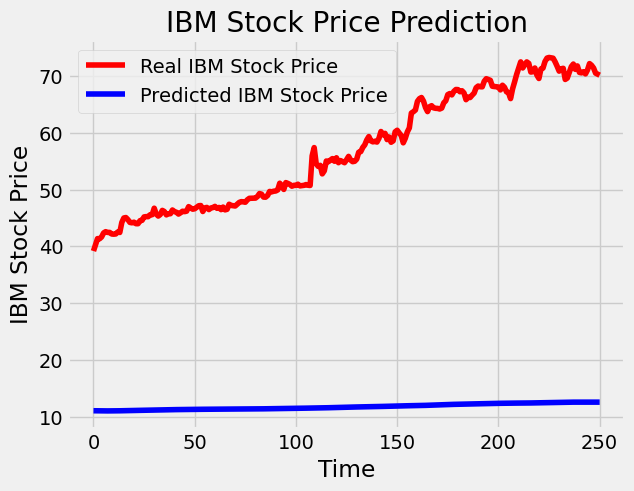

In [38]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [39]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 46.20879208820535.


In [45]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

1/1 [==============================] - 0s 31ms/step


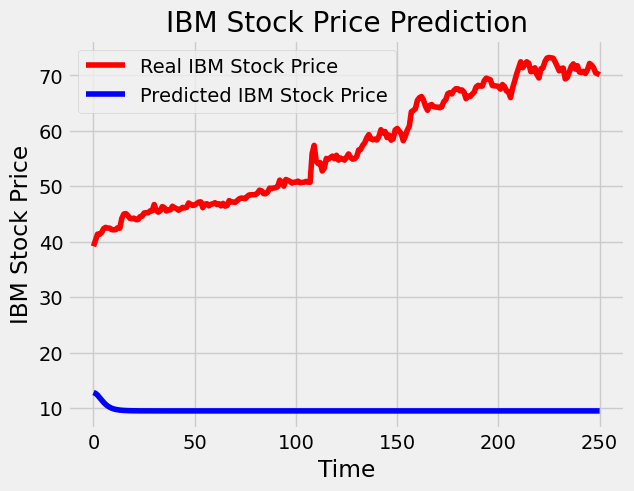

In [46]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [47]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 48.51820324221912.


In [52]:
# Extracting the series
series = dataset[['Close','High','Volume']] # Picking the multivariate series
print(series.shape)
print(series.tail())

(3019, 3)
            Close   High    Volume
Date                              
2017-12-22  71.58  71.87  10979165
2017-12-26  69.86  71.39   8542802
2017-12-27  70.06  70.49   6345124
2017-12-28  69.82  70.32   7556877
2017-12-29  69.85  70.13   6613070


In [57]:
timesteps = 30
hl = [50,45]
lr = 1e-3
batch_size = 32
num_epochs = 200

In [60]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model # Deletes the model
# Load a model
#model = load_model('model_simple_30_[50,45]_1e-3_32.h5')

CROSS VALIDATION

In [61]:
# Hyperparameters
timesteps = 30
hl = [50,45]
lr = 1e-3
batch_size = 32
num_epochs = 50

In [63]:
# Extracting the series
print(series.shape)
print(series.tail())

(3019, 3)
            Close   High    Volume
Date                              
2017-12-22  71.58  71.87  10979165
2017-12-26  69.86  71.39   8542802
2017-12-27  70.06  70.49   6345124
2017-12-28  69.82  70.32   7556877
2017-12-29  69.85  70.13   6613070


In [64]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[0.4995311 , 0.4977262 , 0.05109797],
       [0.5004689 , 0.50838952, 0.04266499],
       [0.50922163, 0.50572369, 0.02496157],
       ...,
       [0.95514223, 0.95671946, 0.01009887],
       [0.95139106, 0.95405363, 0.01287626],
       [0.95185996, 0.95107417, 0.01071301]])

In [65]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

In [74]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
print("Split 1")

Split 1


In [86]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)
print("Split 2")


Split 2


In [87]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = nan
Avg. RMSE = nan
Avg. R2-score = nan


In [88]:
CV_results.to_csv('MV3-RNN_CrossValidation.csv')
train_loss.to_csv('MV3-RNN_CrossValidation_TrainLoss.csv')
val_loss.to_csv('MV3-RNN_CrossValidation_ValLoss.csv')